In [1]:
# !pip install umap-learn ipdb
# !pip install jupyter-dash
# !pip install ipympl
# !jupyter nbextension enable --py --sys-prefix ipympl
## RUN THIS AS A NOTEBOOK! help-->Launch Classic Notebook

In [25]:
%matplotlib inline
# %matplotlib widget
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join
from cifarclass import cifar100_classes
from scipy.interpolate import interp1d

import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
import umap

label_mapping=cifar100_classes
classes = list(label_mapping.values())

alpha =0.2 
markersize=12

indices = np.random.default_rng(1).choice(np.arange(10000), size=10)

In [3]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

print("loading data")
grouped = load_pickle('../processed/cifar100/resnets/group2.pkl')
groups = list(grouped[name].keys())
group = groups[0]
print(groups)
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

loading data
['Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121']
done
loading dataset
Files already downloaded and verified
done


In [4]:
# preprocessing: compute soft-accuracies
def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

# groups = list(grouped[name].keys())
# print(groups)
group = groups[0]

softacc = probs_to_softacc(grouped[name]['Resnet18']['probs'])

In [5]:
def cut_labels(y, labels, k=8):
    good = np.argpartition(np.sum(y, axis=1), -k)[-k:]
    bad = set(range(100)).difference(set(list(good)))
    for i in bad:
        labels[i] = '_nolegend_'
    return labels

def stackplot(index, types = ["probs","freqs"], plot_group = "Resnet18"):
    dct = grouped[name][plot_group]
    print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

    for t in types:
        print(t)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
        y = dct[t][index].copy() # probs/freqs
        
        ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
        #set_trace()
        print(f"Top 5 are {ind[:5]}")
        print(f"Prediction is {classes[ind[0]]}")
        y = y[ind]
        labels = [classes[ind[i]] for i in range(len(classes))]
        new_label = list(ind).index(label)
        
        # swap in the true-label as the first label in list (and in y)
        labels[0], labels[new_label] = labels[new_label], labels[0]
        y[[0,new_label]] = y[[new_label,0]]
        
        #truth = classes[label]
        labels = cut_labels(y, labels)
        #labels[0] = truth
        

            
        if t=="probs":
            xx = probs_to_softacc(dct["probs"])
            ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Softmax probabilities", fontsize=16)
        
        else:
            xx = dct["x"]
            ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Frequency of predictions", fontsize=16)
            
        
        ax1.stackplot(xx, y, labels=labels, colors = col)
        ax1.set_title(
            "Train %s, architecture %s" % (train_set, plot_group),
            fontsize=20,
        )

        ax1.legend(loc="best")
        ax2.imshow(img, interpolation="nearest")
        ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        plt.show()

index 4731
probs
Top 5 are [89 81 13 48 41]
Prediction is tractor


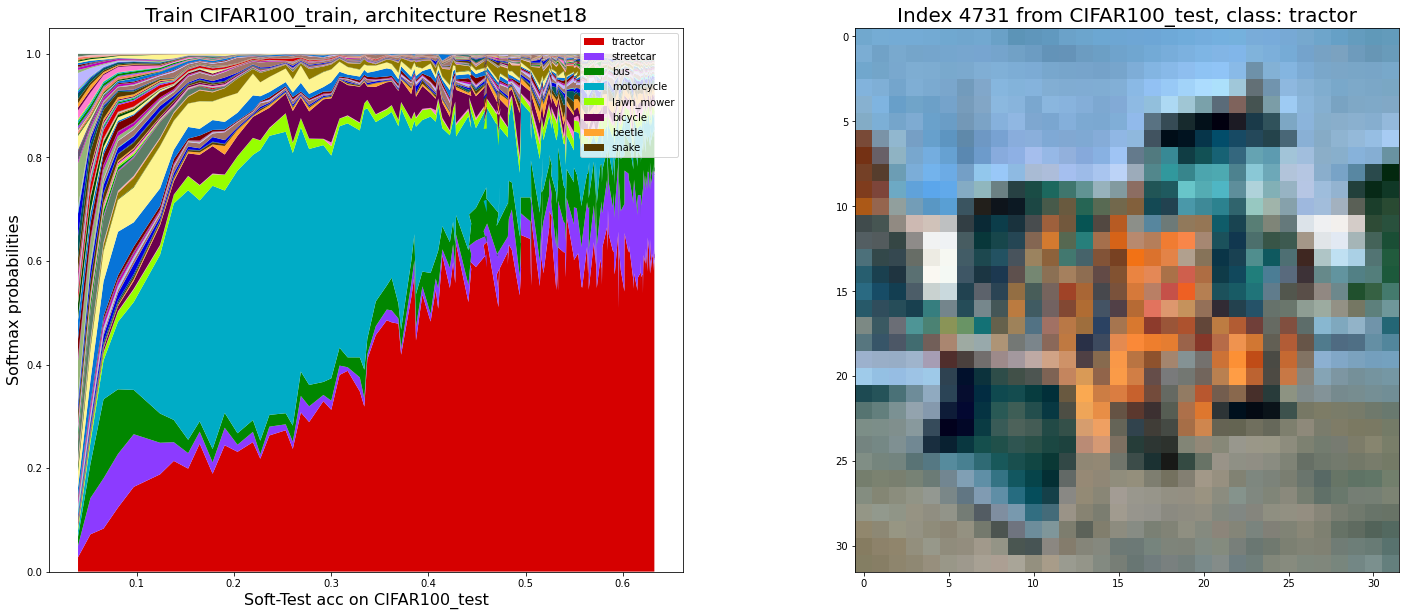

freqs
Top 5 are [89 81 13  8 99]
Prediction is tractor


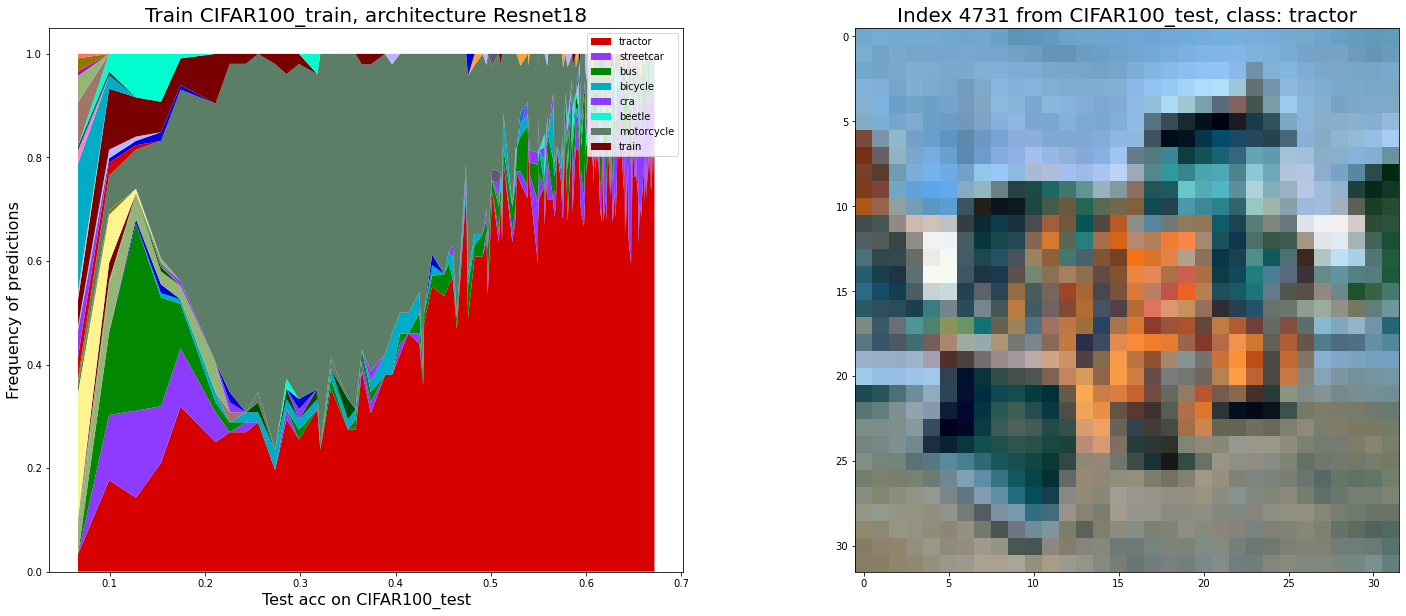

index 5118
probs
Top 5 are [98 35 11 78 26]
Prediction is woman


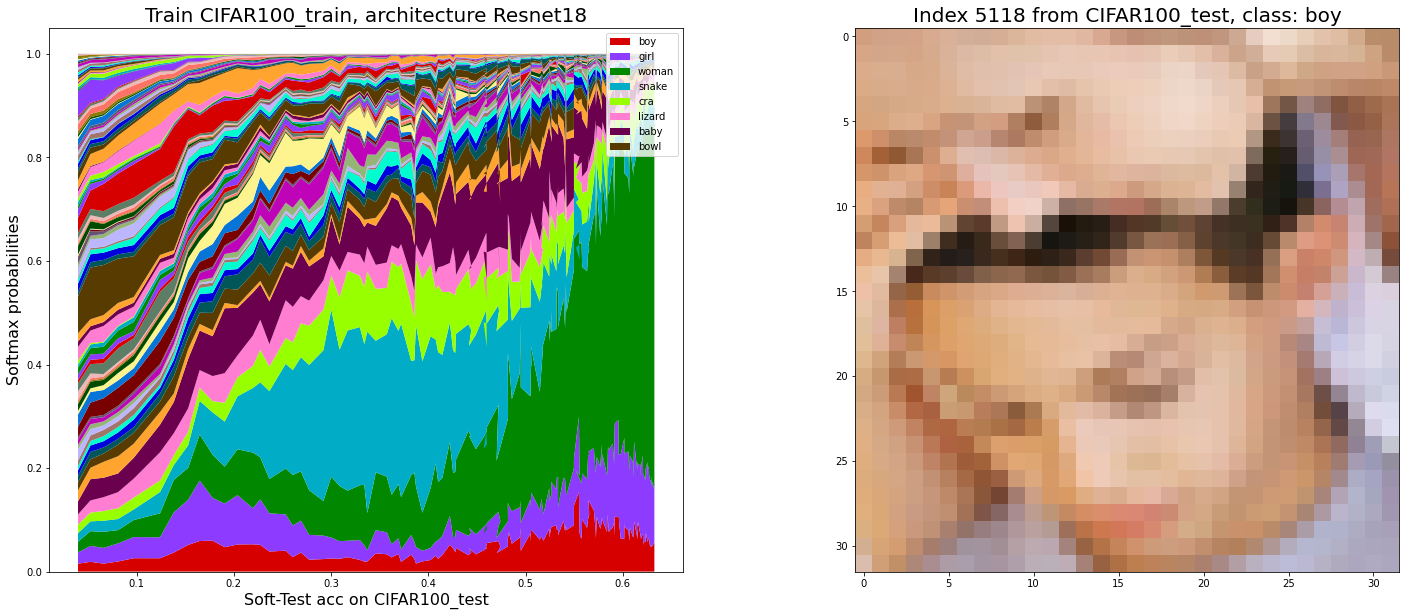

freqs
Top 5 are [98 35 11 78 26]
Prediction is woman


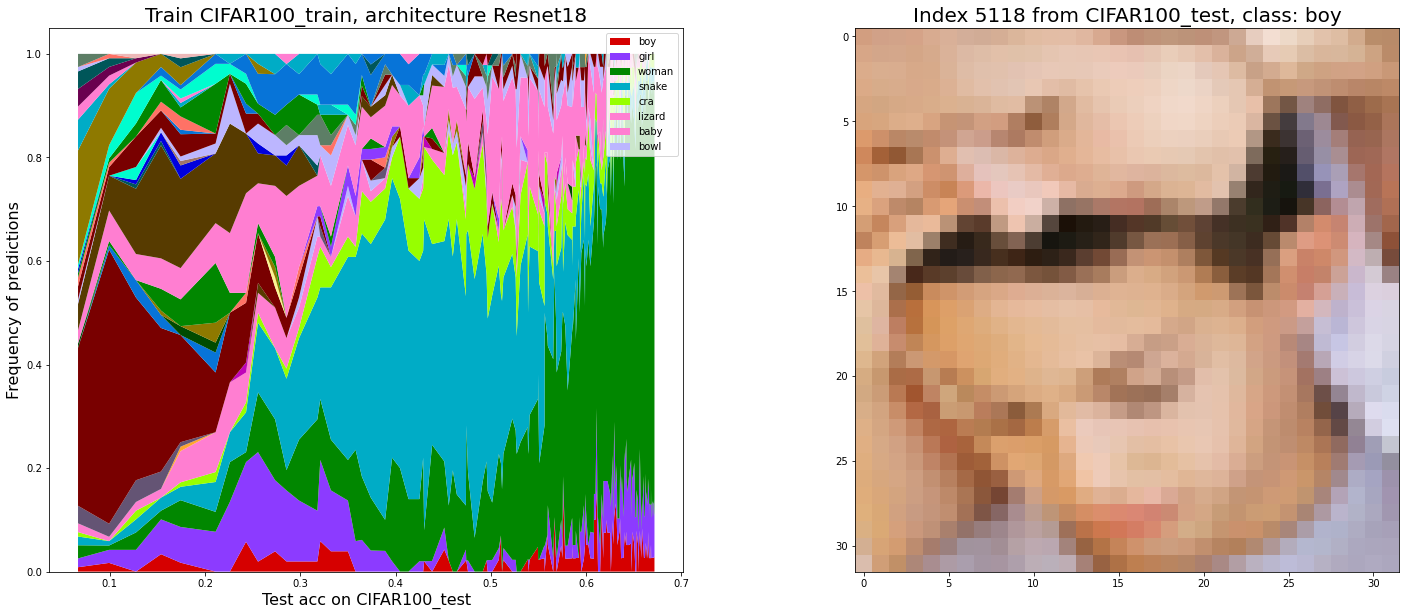

index 7551
probs
Top 5 are [12 81 13 90 40]
Prediction is bridge


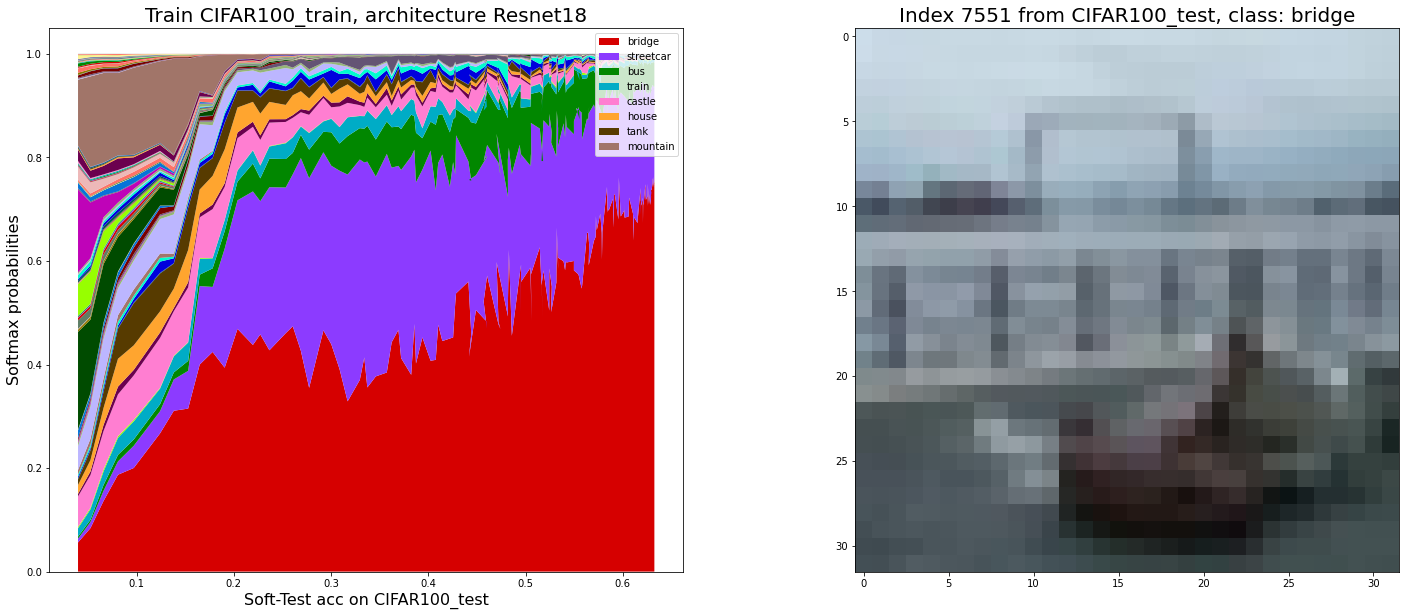

freqs
Top 5 are [12 81 24 26 27]
Prediction is bridge


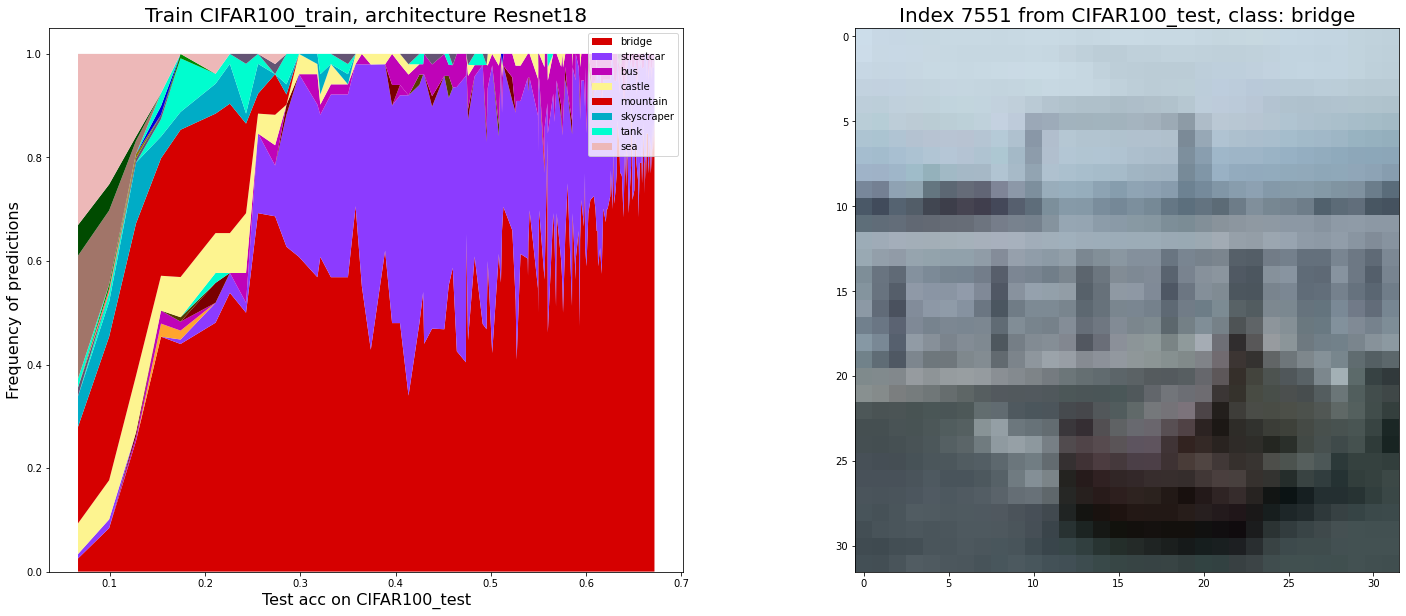

index 9504
probs
Top 5 are [90 58 81 71 13]
Prediction is train


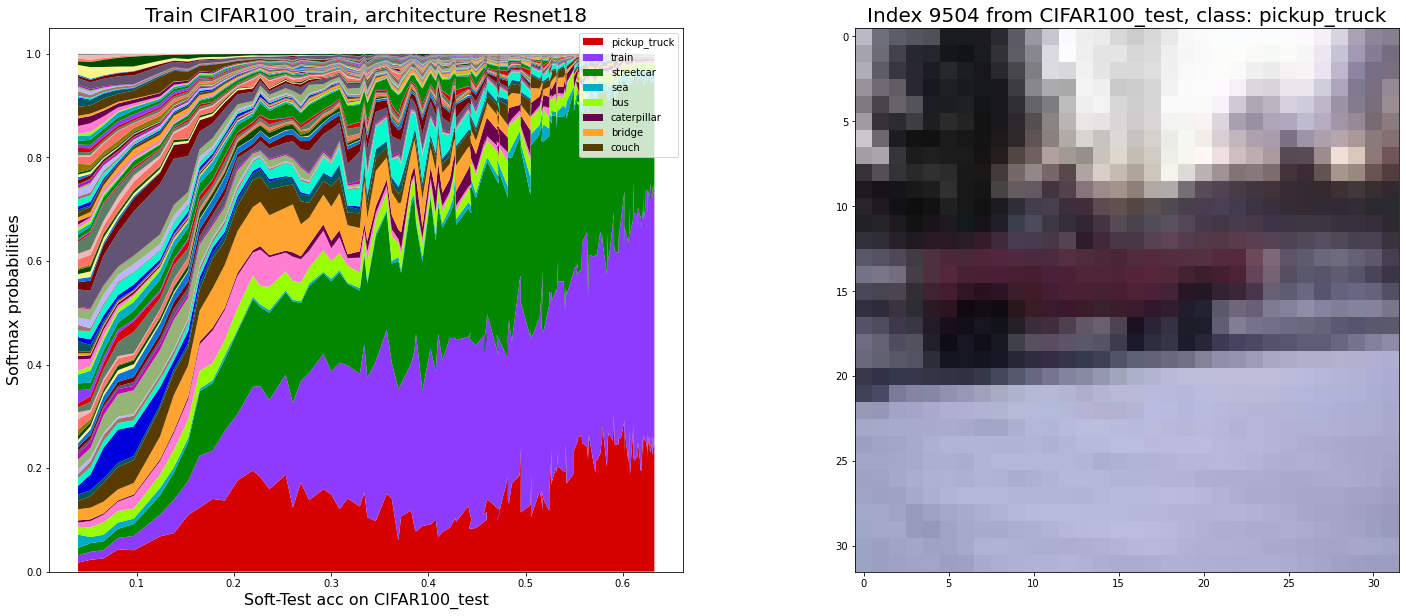

freqs
Top 5 are [90 58 81 99 35]
Prediction is train


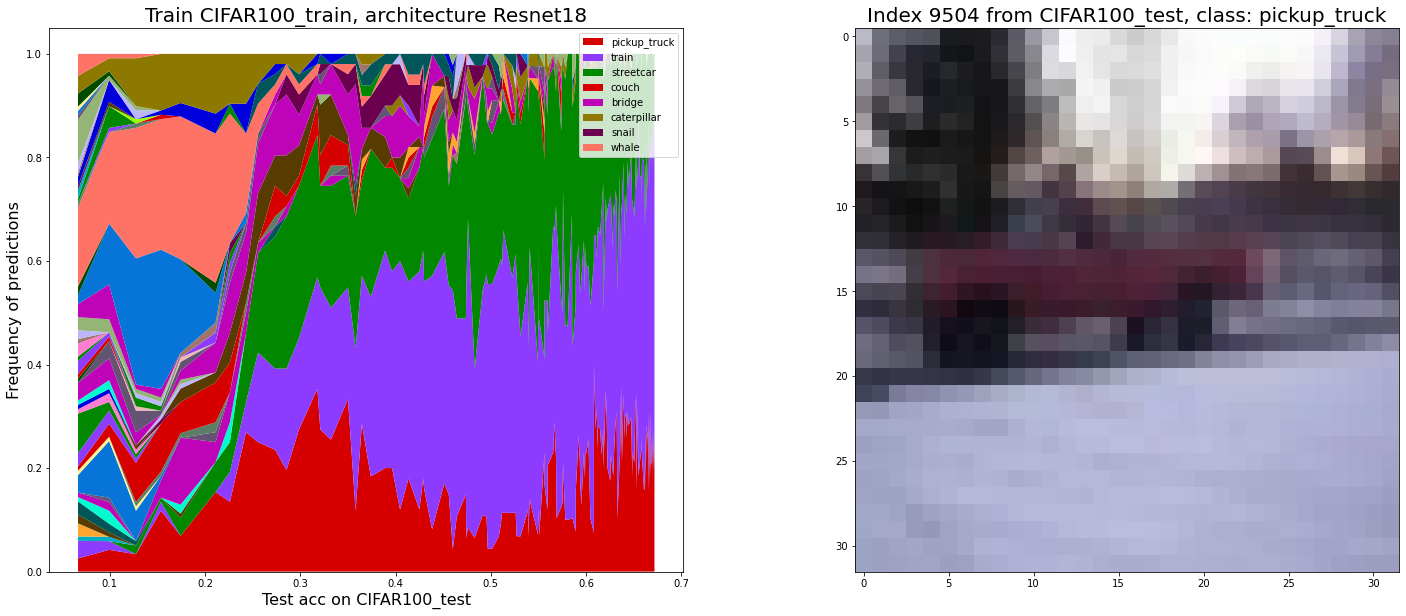

index 348
probs
Top 5 are [10 93 73 18 33]
Prediction is bowl


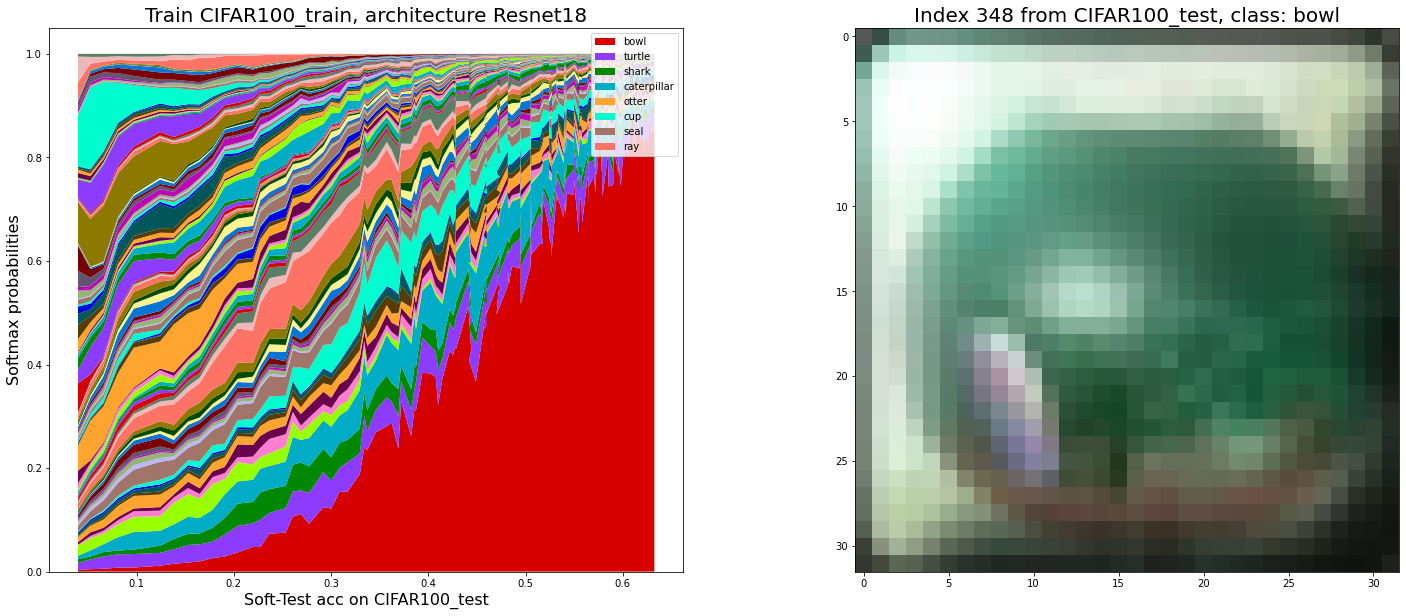

freqs
Top 5 are [10 33 99 37 27]
Prediction is bowl


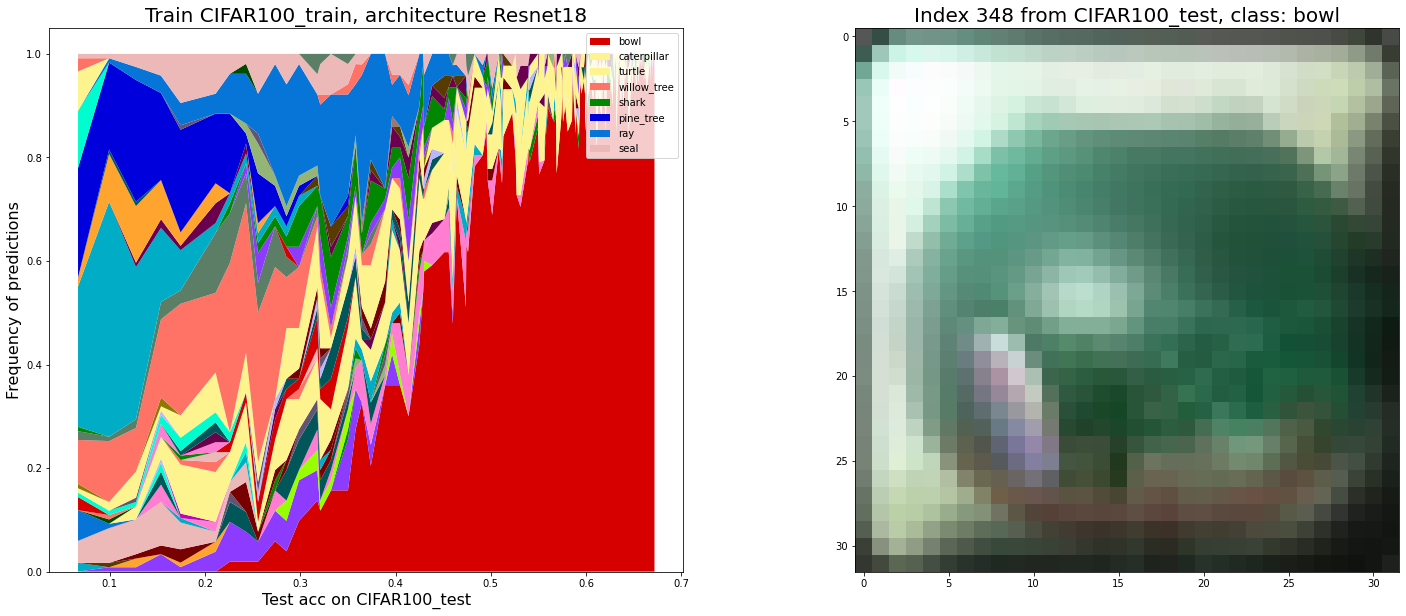

index 1441
probs
Top 5 are [57  9 69 53 40]
Prediction is pear


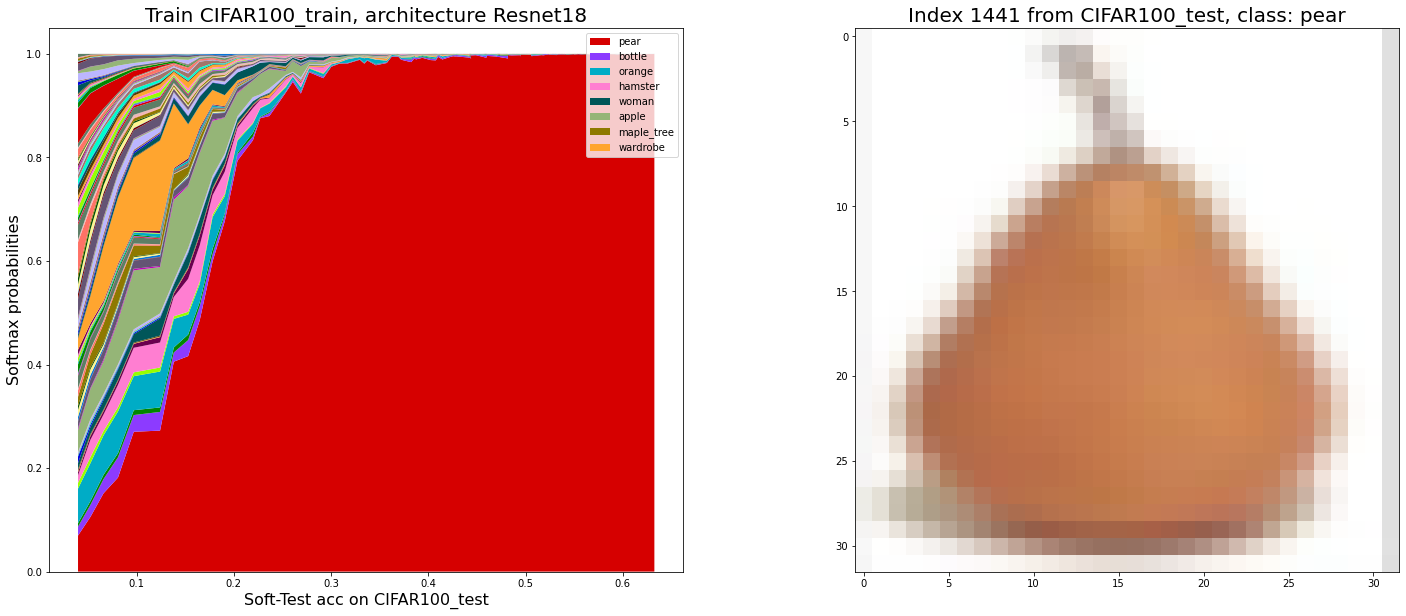

freqs
Top 5 are [57 99 36 26 27]
Prediction is pear


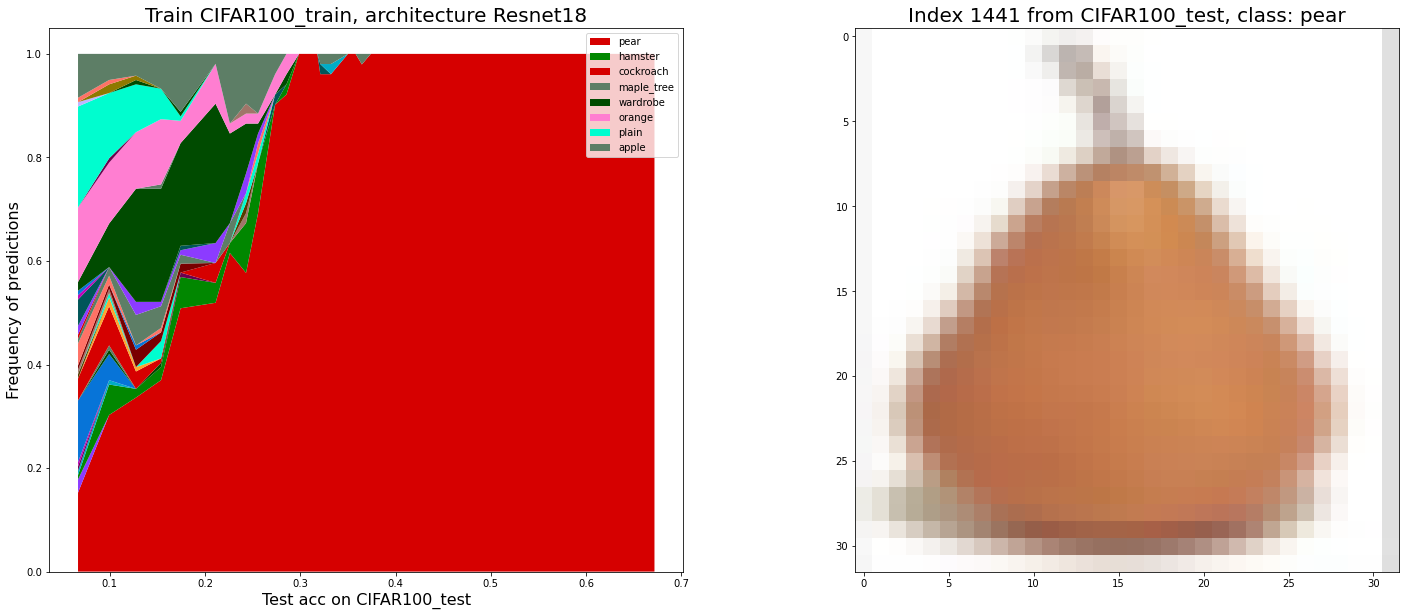

index 8229
probs
Top 5 are [75 40 41 16 90]
Prediction is skunk


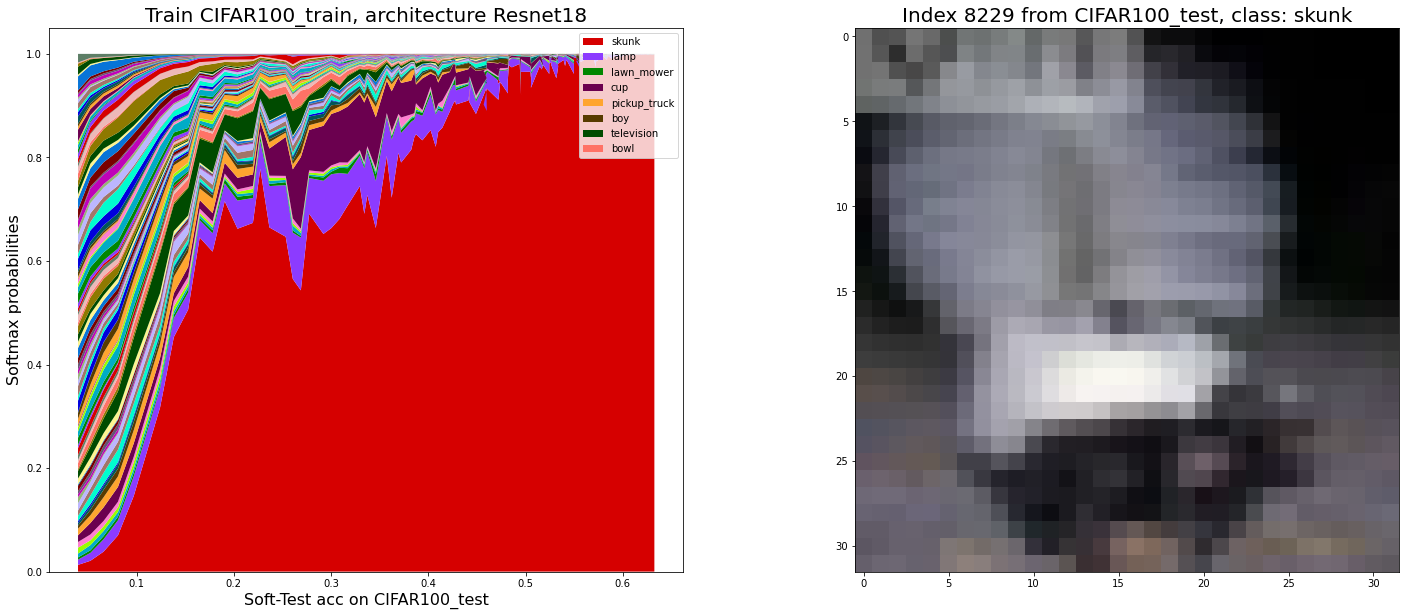

freqs
Top 5 are [75 35 25 26 27]
Prediction is skunk


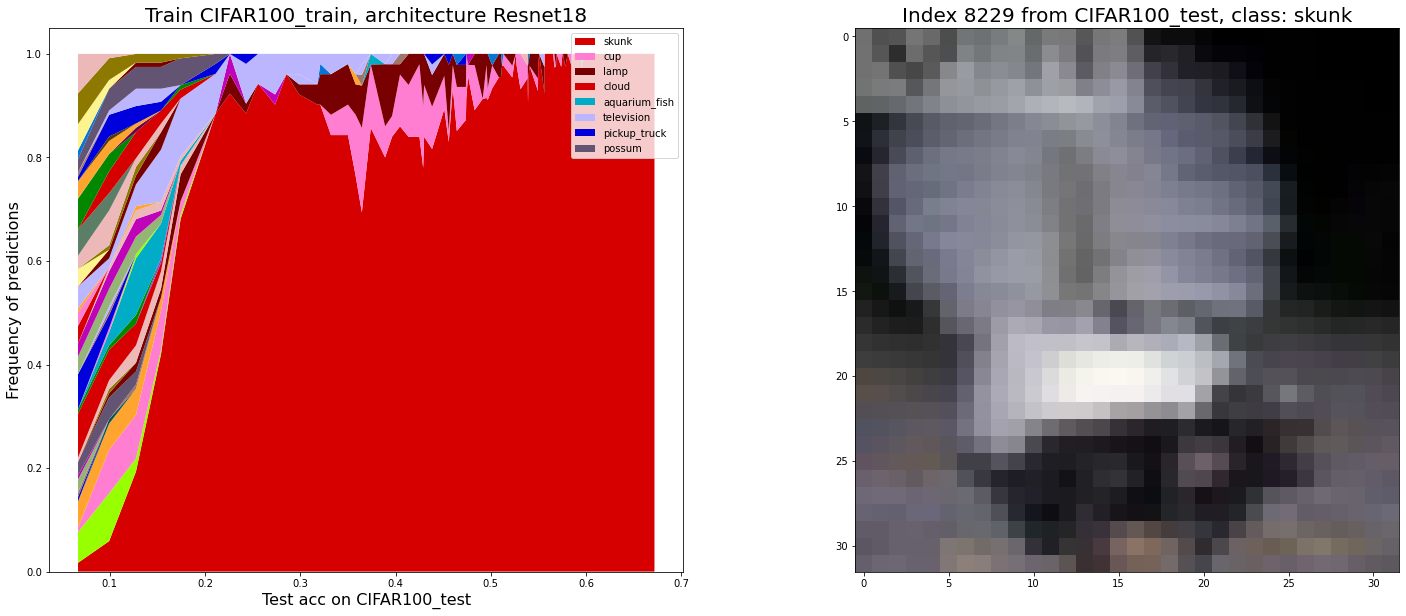

index 9486
probs
Top 5 are [ 8 46 79 40 11]
Prediction is bicycle


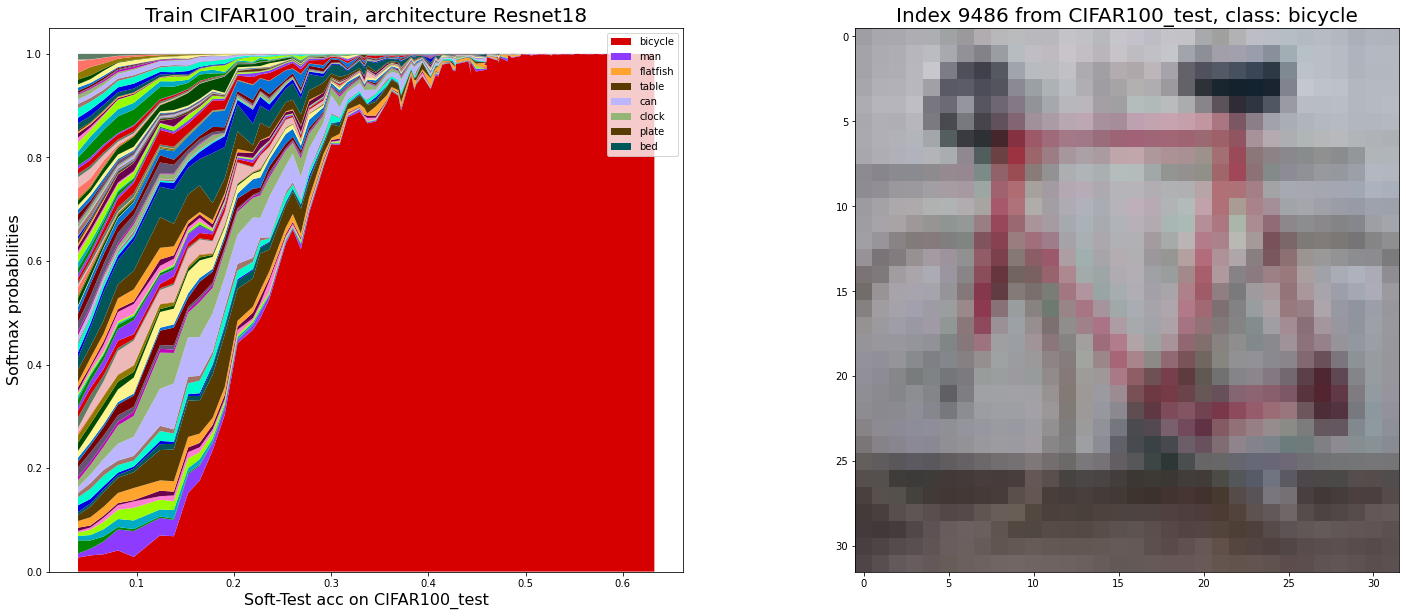

freqs
Top 5 are [ 8 99 37 27 28]
Prediction is bicycle


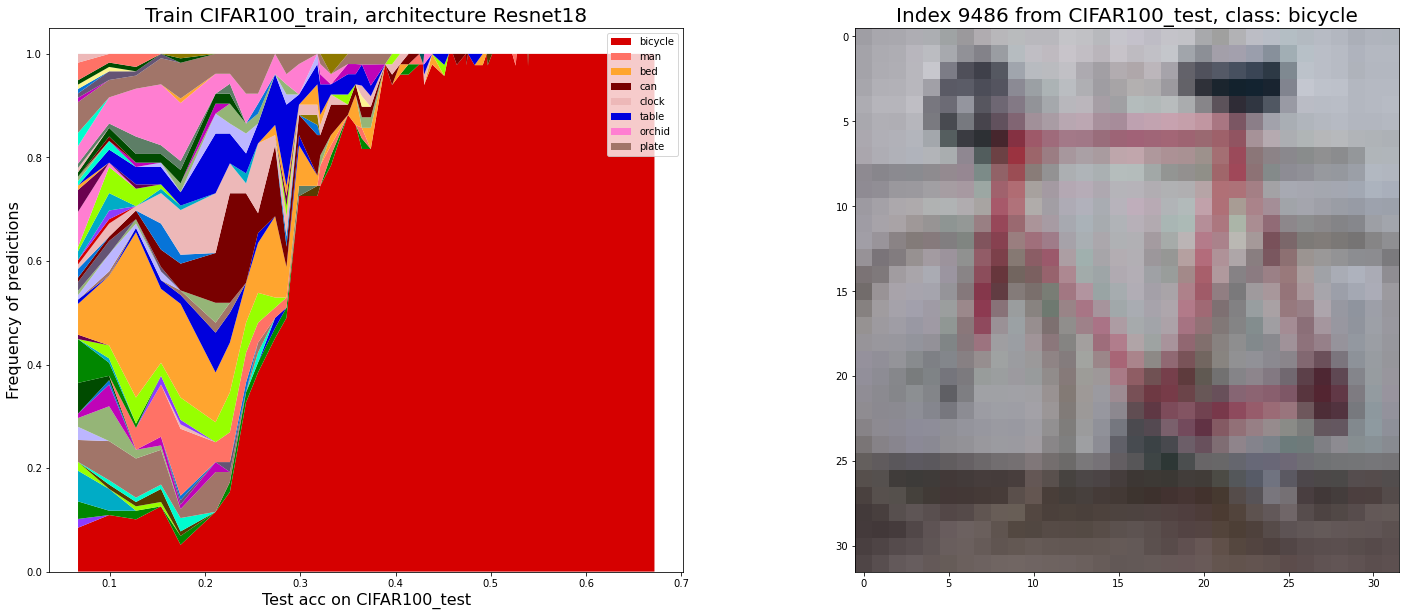

index 2492
probs
Top 5 are [85 15 97 48 89]
Prediction is tank


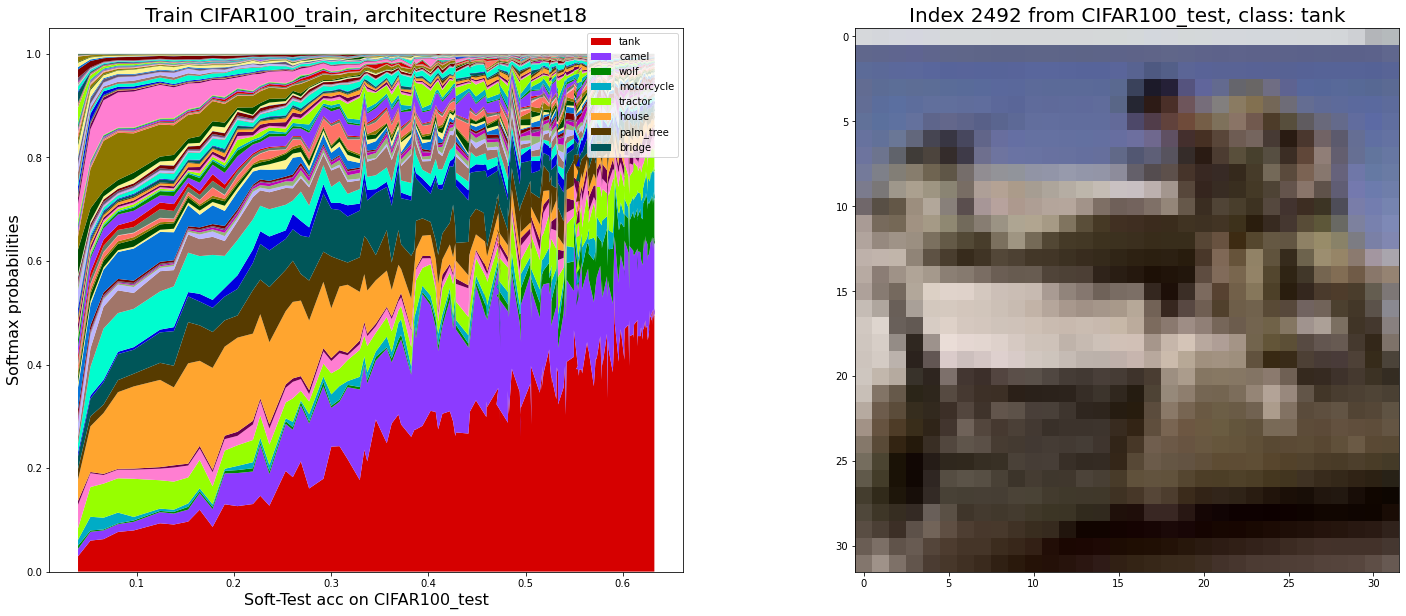

freqs
Top 5 are [85 15 97 89 12]
Prediction is tank


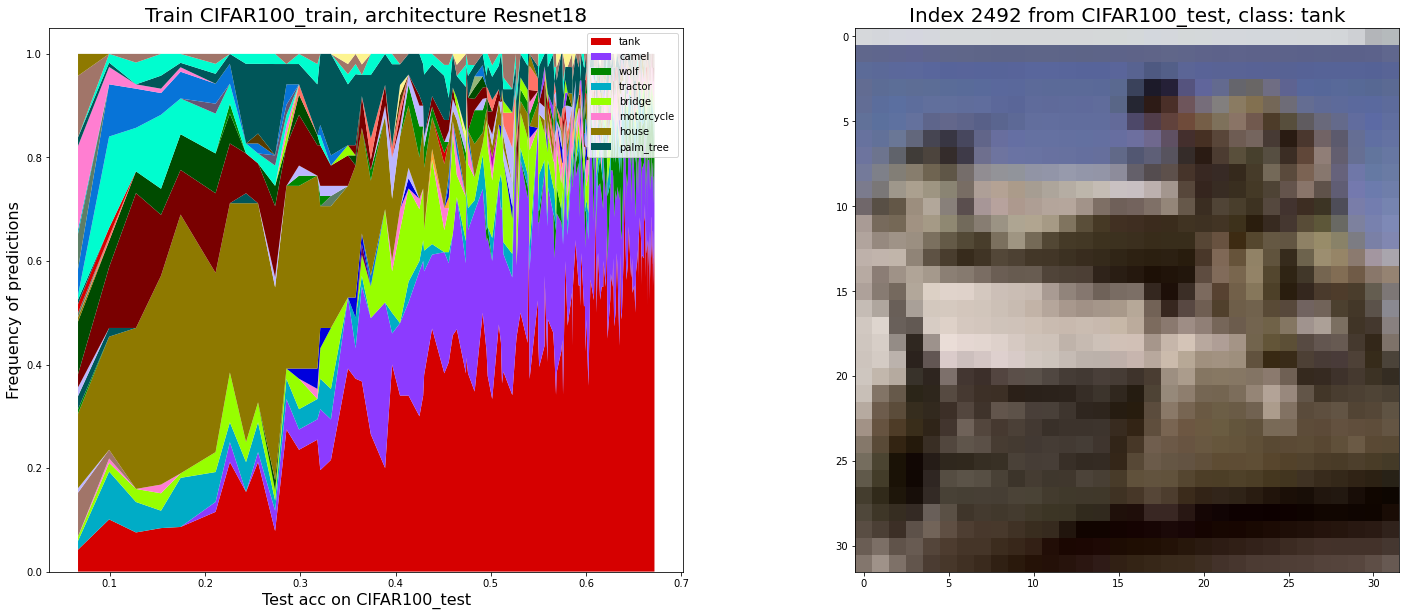

index 3118
probs
Top 5 are [31 21 27 29 55]
Prediction is elephant


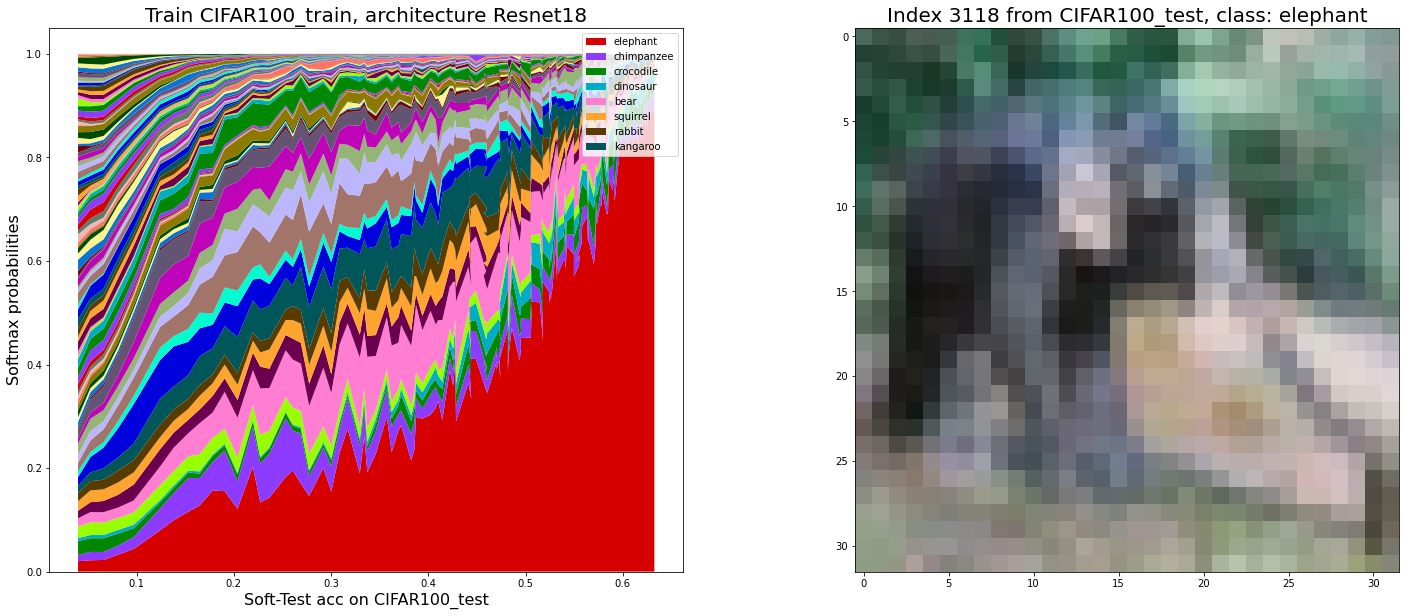

freqs
Top 5 are [31 27 99 36 26]
Prediction is elephant


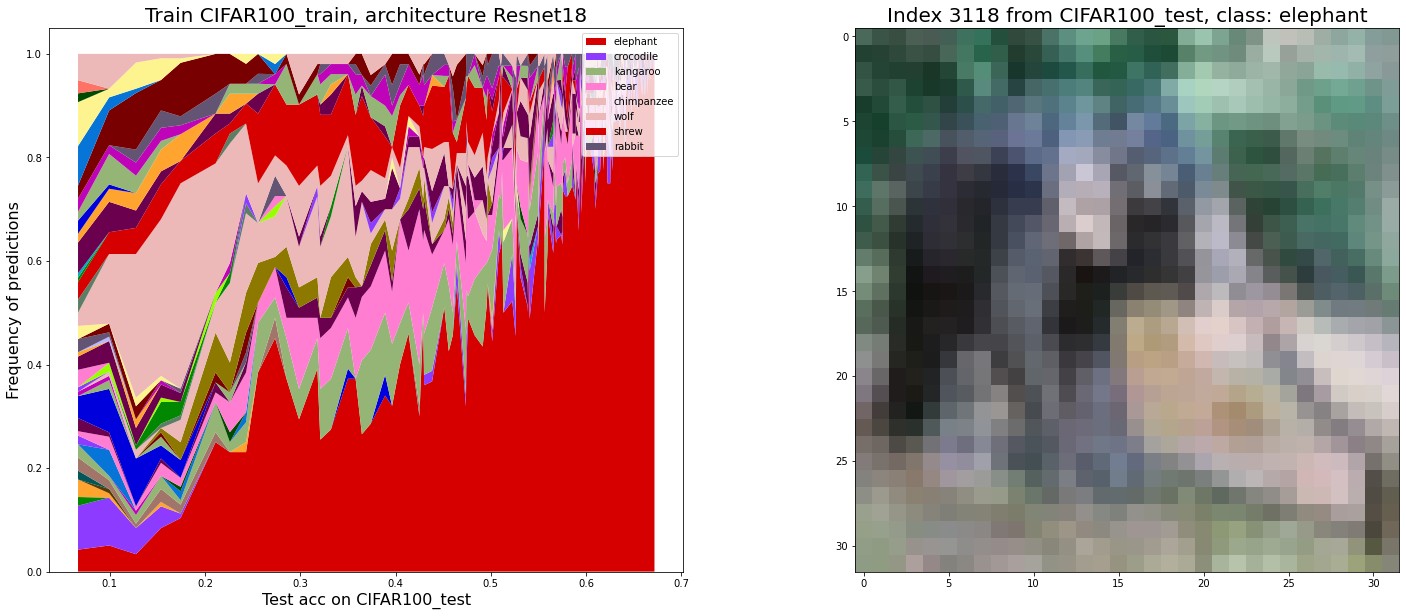

In [137]:
for idx in indices:
    stackplot(idx, types=["probs", "freqs"], plot_group='Resnet18')

In [156]:
G = grouped[name][group]

def get_embedding(index, G=grouped[name][group], t="probs", topk=5, gridpts=50):
    true_label = ytest[index]
    
    
    if t=="probs":
        x = probs_to_softacc(G["probs"])
    else:
        x = G["x"]
        
    areas = G[t][index].sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals
    top_labels = ind[:topk]

    embed = []
    xx = np.linspace(x.min(), x.max(), gridpts)
    for lab in top_labels:
        # linearly interpolate the curve on uniform grid
        y = G[t][index][lab]
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        embed.append(yy)
    return np.array(embed) # topk x gridpts

(5, 20)


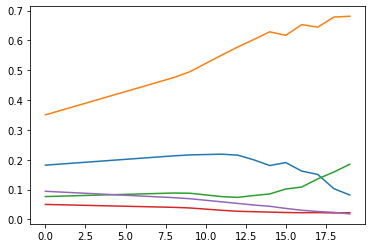

In [154]:
e = get_embedding(np.random.randint(10000), topk=5, gridpts=20, t="probs")
print(e.shape)
plt.figure()
for i in range(len(e)):
    plt.plot(e[i])
plt.show()

In [ ]:
N = 2000
TOPK = 5
GRIDPTS = 20
TYPE="probs"
X = np.array([ get_embedding(i, topk=TOPK, gridpts=GRIDPTS, t=TYPE).flatten() for i in range(N) ])
print(X.shape)

Xt = umap.UMAP(min_dist=0.0, n_neighbors=10).fit_transform(X)
print(Xt.shape)

final_accs = np.array([G["freqs"][i, yi, -1] for i, yi in enumerate(ytest)])

plt.figure(figsize=(10,7))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[:N], cmap='Spectral')
plt.colorbar(sc, label='Final Pointwise Test Acc')
plt.show()

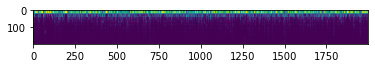

In [134]:
plt.imshow(X.T)

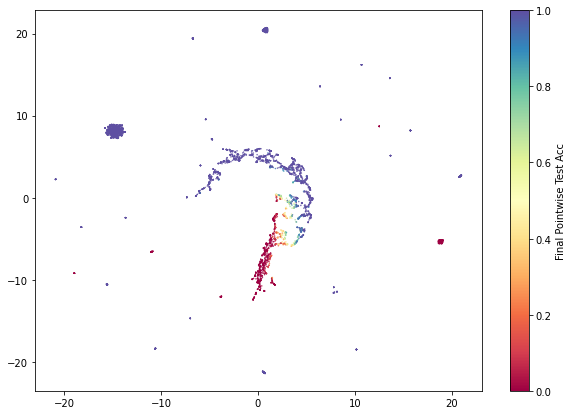

In [72]:
Xt = umap.UMAP(min_dist=0.0, n_neighbors=10).fit_transform(X)
final_accs = np.array([G["freqs"][i, yi, -1] for i, yi in enumerate(ytest)])
fig = plt.figure(figsize=(10,7))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[:N], cmap='Spectral')
plt.colorbar(sc, label='Final Pointwise Test Acc')
plt.show()

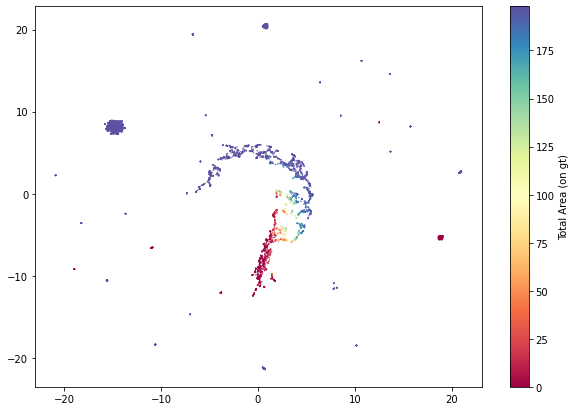

In [83]:
fig = plt.figure(figsize=(10,7))
areas = np.array([np.sum(G["freqs"][i, yi, :]) for i, yi in enumerate(ytest)])
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=areas[:N], cmap='Spectral')
plt.colorbar(sc, label='Total Area (on gt)')
plt.show()

In [19]:
from ipywidgets import Image, HTML, VBox, Output
from IPython.display import display, clear_output
import PIL

def tobytes(a, fmt='png'):
    from io import BytesIO
    import PIL.Image
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()

img = Image(value=tobytes(dataset[0][0]), height=64, width=64)
img

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00 \x00\x00\x00 \x08\x02\x00\x00\x00\xfc\x18\xed\xa…

In [135]:
import plotly.graph_objs as go
import plotly.express as px

df = pd.DataFrame(Xt, columns=('x', 'y'))
df['class'] = [classes[ytest[i]] for i in range(N)]
df['final_acc'] = final_accs[:N]

n = 200
fig = go.FigureWidget(
    data=[
        dict(
            type='scattergl',
            x=Xt[:n, 0],
            y=Xt[:n, 1],
            marker=dict(color=final_accs[:n], colorscale='Spectral'),
            text=df['class'][:n],
            mode='markers'
        )
    ],
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600)
fig

FigureWidget({
    'data': [{'marker': {'color': array([1.        , 0.        , 0.        , 1.        , 1.    …

    'data': [{'marker': {'color': array([1.        , 0.        , 0.        , 1. …

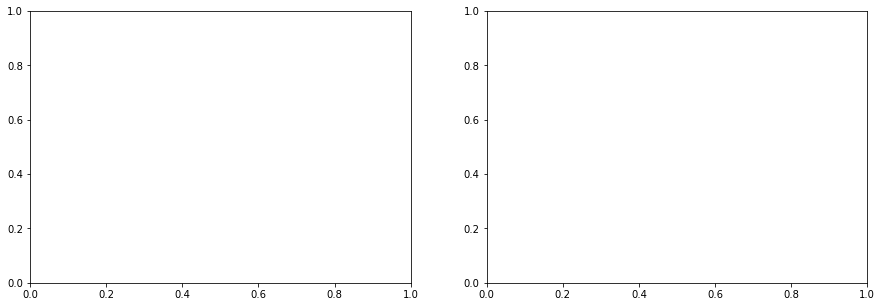

In [136]:

def singlestack(fig, index, t = "freqs", plot_group = "Resnet18"):
    ax1, ax2 = fig.axes
    
    
    dct = grouped[name][plot_group]
#     print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

        
    y = dct[t][index].copy() # probs/freqs

    ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
    #         print(f"Top 5 are {ind[:5]}")
    #         print(f"Prediction is {classes[ind[0]]}")
    y = y[ind]
    labels = [classes[ind[i]] for i in range(len(classes))]
    new_label = list(ind).index(label)

    # swap in the true-label as the first label in list (and in y)
    labels[0], labels[new_label] = labels[new_label], labels[0]
    y[[0,new_label]] = y[[new_label,0]]
    labels = cut_labels(y, labels)

    if t=="probs":
        xx = probs_to_softacc(dct["probs"])
        ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
        ax1.set_ylabel("Softmax probabilities", fontsize=16)

    else:
        xx = dct["x"]
        ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
        ax1.set_ylabel("Frequency of predictions", fontsize=16)


    ax1.stackplot(xx, y, labels=labels, colors = col)
    ax1.set_title(
        "Train %s, architecture %s" % (train_set, plot_group),
        fontsize=20,
    )

    ax1.legend(loc="best")
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# singlestack(f, index=0)

out = Output() 
# with out:
#     display(f)
    
image_widget = Image(value=tobytes(dataset[0][0]), height=64, width=64)


ind = 0

def hover_fn(trace, points, state):
    # Update image widget
    ind = points.point_inds[0]
    # print(ind)
    image_widget.value = tobytes(dataset[ind][0])
    
    with out:
        out.clear_output(wait=True)
        for ax in [ax1, ax2]:
            ax.clear()
        singlestack(f, index=ind)
        display(f)
    

    

    
scatter = fig.data[0]
scatter.on_hover(hover_fn)

VBox([fig, image_widget, out])

In [49]:
out

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x360 with 2 Axes>', 'i…

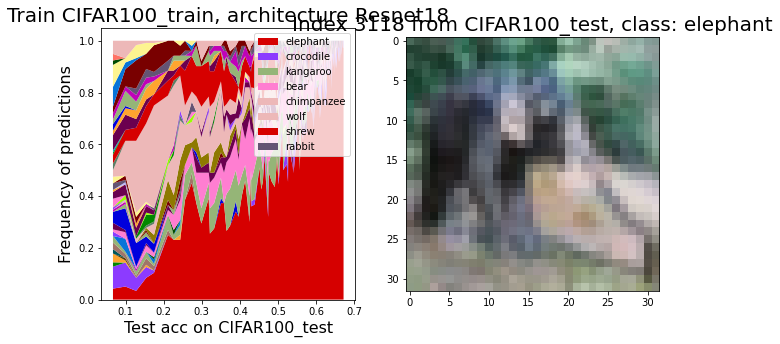

In [54]:
f